## What is Lending Club?
LendingClub is a US peer-to-peer lending company.Lending Club enables borrowers to create loan listings on its website by supplying details about themselves and the loans that they would like to request. All loans are unsecured personal loans and can be between \$1,000 - \$40,000. On the basis of the borrower’s credit score, credit history, desired loan amount and the borrower’s debt-to-income ratio, Lending Club determines whether the borrower is credit worthy and assigns to its approved loans a credit grade that determines payable interest rate and fees. The standard loan period is three years; a five-year period is available at a higher interest rate and additional fees. The loans can be repaid at any time without penalty.

Each borrower fills out a comprehensive application, providing their past financial history, the reason for the loan, and more. Lending Club evaluates each borrower's credit score using past historical data (and their own data science process!) and assigns an interest rate to the borrower. 

Investors are primarily interested in receiving a return on their investments. Approved loans are listed on the Lending Club website, where qualified investors can browse recently approved loans, the borrower's credit score, the purpose for the loan, and other information from the application.
Once an investor decides to fund a loan, the borrower then makes monthly payments back to Lending Club. Lending Club redistributes these payments to the investors. This means that investors don't have to wait until the full amount is paid off to start to see money back. If a loan is fully paid off on time, the investors make a return which corresponds to the interest rate the borrower had to pay in addition to the requested amount. Many loans aren't completely paid off on time, however, and some borrowers default on the loan.

## Alright, then what is the data challenge here? What is the problem you are trying to solve?

Suppose an investor has approached us and has asked us to build a machine learning model that can reliably predict if a loan will be paid off or not. This investor described himself/herself as a conservative investor who only wants to invest in loans that have a good chance of being paid off on time. Thus, this client is more interested in a machine learning model which does a good job of filtering out high percentage of loan defaulters.

## Thus, Out Target is to build a predictive model that will tell us if there is a high risk of loan getting defaulted

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import  SMOTE
from sklearn.model_selection import  train_test_split

In [2]:
data = pd.read_csv('lending_club_loans.csv',low_memory=False,skiprows=1)#first row seems to have URL - We'll skip it

## Step 0:  Preparing the data for our problem statement (Handling Data Leakage and Feature Engineering)

We are interested in determining whether or not the loan will be defaulted. We cannot use all the variables currently available in the dataset for thsi purpose - for a simple reason that many of them will not be available to us when we are making a decision if loan should be processed or not.

Additionally we will eliminate every feature which:

1 leaks information from the future (after the loan has already been funded),

2 don't affect the borrower's ability to pay back the loan (e.g. a randomly generated ID value by Lending Club),

3 is formatted poorly,

4 requires more data or a lot of preprocessing to turn into useful a feature, or

5 contains redundant information.



After analyzing the columns, we can conclude that the following features can be removed:

id — randomly generated field by Lending Club for unique identification purposes only.

member_id — also randomly generated field by Lending Club for identification purposes only.

funded_amnt — leaks information from the future(after the loan is already started to be funded).

funded_amnt_inv — also leaks data from the future.

sub_grade — contains redundant information that is already in the grade column (more below).

int_rate — also included within the grade column.

emp_title — requires other data and a lot of processing to become potentially useful

issued_d — leaks data from the future.

zip_code - mostly redundant with the addr_state column since only the first 3 digits of the 5 digit zip code are visible.

out_prncp - leaks data from the future.

out_prncp_inv - also leaks data from the future.

total_pymnt - also leaks data from the future.

total_pymnt_inv - also leaks data from the future.

Also, all below colums won't be available for us when deciding about the loan:

total_rec_prncp -also leaks data from the future

total_rec_int -also leaks data from the future

total_rec_late_fee -also leaks data from the future

recoveries -also leaks data from the future

collection_recovery_fee -also leaks data from the future

last_pymnt_d -also leaks data from the future

last_pymnt_amnt -also leaks data from the future

title - COntains redundant information. We'll keep 'Purpose' column instead of this one

addr_state - too many unique values - requires extensive feature engineering (grouping)

The payment plan column (pymnt_plan) has two unique values, 'y' and 'n', with 'y' occurring only once. Let's drop this column:

earliest_cr_line — The month the borrower's earliest reported credit line was opened - Requires extensive feature engineering 
last_credit_pull_d — The most recent month Lending Club pulled credit for this loan - Requires extensive feature engineering 

If we go for more careful analysis of the four FICO score fields, we can conclude that we can use fico_range_low, fico_range_high. However we CANNOT use last_fico_range_low and last_fico_range_high as these leak information from the future and **accuracy of our model will be incorrectly high** if we used these.

Let's go ahead and drop all the features analyzed above.


Treatment of FICO columns - It is highly unlikely that we will grant loan with missing FICO details - we cannot have missing values here and we will use average of these two scores

42538
42535


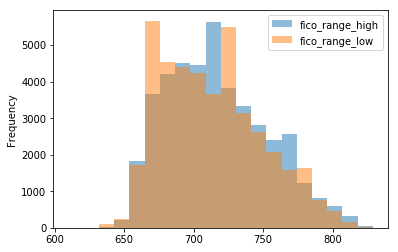

In [3]:
fico_columns = ['fico_range_high','fico_range_low']

print(data.shape[0])
data.dropna(subset=fico_columns,inplace=True)
print(data.shape[0])

data[fico_columns].plot.hist(alpha=0.5,bins=20);

In [4]:
data['fico_avg'] = (data['fico_range_high'] +data['fico_range_low'])/2

In [5]:
drop_cols = ['id','member_id','funded_amnt','funded_amnt_inv',
             'int_rate','sub_grade','emp_title','issue_d','zip_code','out_prncp','out_prncp_inv',
             'total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int', 'total_rec_late_fee',
             'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
             'last_pymnt_amnt','fico_range_low','fico_range_high','last_fico_range_low',
             'last_fico_range_high','url','desc','earliest_cr_line','last_credit_pull_d','title','addr_state','pymnt_plan']

In [6]:
X = data.drop(drop_cols,axis=1)

In [7]:
X.shape

(42535, 85)

### Lets drop the columns with :
1. More than 80% values missing ( There is a better way to handle thsi than dropping them but let's start with simple way
2. Having a unique value (Which in statistical terms means - Having no variance, no explainatory power)


In [8]:
X.shape

(42535, 85)

In [9]:
X.dropna(axis=1,thresh=0.2*len(X),inplace=True)

In [10]:
X = X.loc[:,X.nunique() !=1]

## Let's check if we have correct data tyes set:

In [11]:
X.dtypes

loan_amnt                 float64
term                       object
installment               float64
grade                      object
emp_length                 object
home_ownership             object
annual_inc                float64
verification_status        object
loan_status                object
purpose                    object
dti                       float64
delinq_2yrs               float64
inq_last_6mths            float64
mths_since_last_delinq    float64
open_acc                  float64
pub_rec                   float64
revol_bal                 float64
revol_util                 object
total_acc                 float64
acc_now_delinq            float64
delinq_amnt               float64
pub_rec_bankruptcies      float64
tax_liens                 float64
fico_avg                  float64
dtype: object

We can see float values are correctly read. Lets focus on the columns with 'object' dtype

In [12]:
X.loc[:,X.dtypes=='object'].head()

,term,grade,emp_length,home_ownership,verification_status,loan_status,purpose,revol_util
0,36 months,B,10+ years,RENT,Verified,Fully Paid,credit_card,83.7%
1,60 months,C,< 1 year,RENT,Source Verified,Charged Off,car,9.4%
2,36 months,C,10+ years,RENT,Not Verified,Fully Paid,small_business,98.5%
3,36 months,C,10+ years,RENT,Source Verified,Fully Paid,other,21%
4,60 months,B,1 year,RENT,Source Verified,Current,other,53.9%


It seems we need to clean revol_util column which has '%' sign in it We need to convert this to float:

In [13]:
X['revol_util'] = X['revol_util'].str.strip('%').astype(float)

In [14]:
X.dtypes

loan_amnt                 float64
term                       object
installment               float64
grade                      object
emp_length                 object
home_ownership             object
annual_inc                float64
verification_status        object
loan_status                object
purpose                    object
dti                       float64
delinq_2yrs               float64
inq_last_6mths            float64
mths_since_last_delinq    float64
open_acc                  float64
pub_rec                   float64
revol_bal                 float64
revol_util                float64
total_acc                 float64
acc_now_delinq            float64
delinq_amnt               float64
pub_rec_bankruptcies      float64
tax_liens                 float64
fico_avg                  float64
dtype: object

Lets Check number of missing values in each column

In [15]:
X.isna().sum().sort_values(ascending=False)

mths_since_last_delinq    26926
pub_rec_bankruptcies       1365
emp_length                 1112
tax_liens                   105
revol_util                   90
delinq_2yrs                  29
open_acc                     29
inq_last_6mths               29
pub_rec                      29
total_acc                    29
acc_now_delinq               29
delinq_amnt                  29
annual_inc                    4
term                          0
installment                   0
grade                         0
home_ownership                0
fico_avg                      0
verification_status           0
loan_status                   0
purpose                       0
dti                           0
revol_bal                     0
loan_amnt                     0
dtype: int64

In [16]:
X.loc[:,X.dtypes=='object'].nunique()

term                    2
grade                   7
emp_length             11
home_ownership          5
verification_status     3
loan_status             9
purpose                14
dtype: int64

## It is important to treat nominal and ordinal values differenty. We should assign numbers to ordinal values so that order is preserved. For nominal values, we should use one hot encoding.

#### Ordinal Values
grade

emp_length
#### Nominal Values
home_ownership

verification_status

purpose

term


In [17]:
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0

    },
    "grade":{
        "A": 1,
        "B": 2,
        "C": 3,
        "D": 4,
        "E": 5,
        "F": 6,
        "G": 7
    }
}

In [18]:
X = X.replace(mapping_dict)
X[['emp_length','grade']].head()

,emp_length,grade
0,10.0,2
1,0.0,3
2,10.0,3
3,10.0,3
4,1.0,2


In [19]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

In [20]:
le = LabelEncoder()

In [21]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

#### Impute Missing Values

In [22]:
DFI = DataFrameImputer()

In [23]:
X = DFI.fit_transform(X=X)

In [24]:
X  = pd.get_dummies(data= X,columns=['home_ownership','verification_status','purpose','term'])

## Recode our target column in suitable form:

#### Let's remove all the loans that don't contain either 'Fully Paid' or 'Charged Off' as the loan's status and then transform the 'Fully Paid' values to 1 for the positive case and the 'Charged Off' values to 0 for the negative case.

In [25]:
X = X[(X["loan_status"] == "Fully Paid") |
                            (X["loan_status"] == "Charged Off")]

mapping_dictionary = {"loan_status":{ "Fully Paid": 1, "Charged Off": 0}}
X = X.replace(mapping_dictionary)

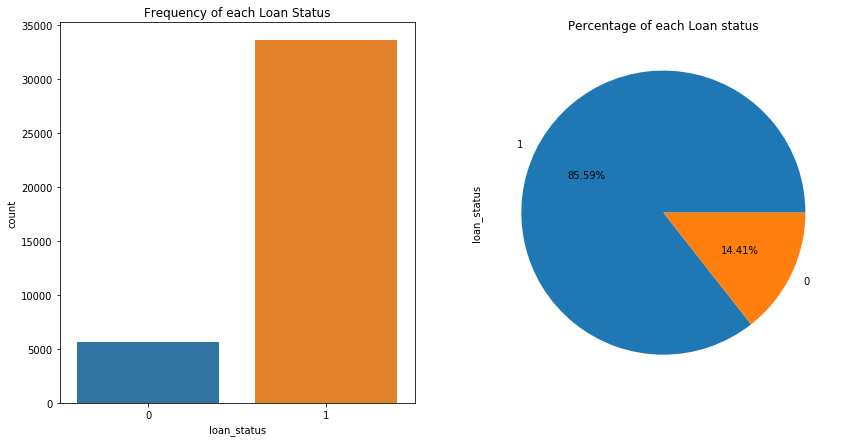

In [26]:
fig, axs = plt.subplots(1,2,figsize=(14,7))
sns.countplot(x='loan_status',data=X,ax=axs[0])
axs[0].set_title("Frequency of each Loan Status")
X.loan_status.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Loan status")
plt.show()

## Step 1: Separate Test data set without getting a peek 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X.drop('loan_status',axis=1), X['loan_status'], test_size=0.30, random_state=42)

## Step 2: Standardize the data ( Rescale)

In [28]:
from sklearn.preprocessing import  StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


## Step 3 : Principal Component Analysis:

This is not a mandatory step. However, if we are not using regularization, this helps in limiting degrees of freedom for our ML algorithms ( number of parameters they have to learn)

In [29]:
from sklearn.decomposition import PCA

In [210]:
pca = PCA(n_components=3)

In [211]:
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
parameters = {'n_estimators':(3,5,8,10,14,16)}

In [35]:
rfc = RandomForestClassifier()

In [36]:
clf = GridSearchCV(rfc,param_grid=parameters,cv=5)

In [37]:
clf.fit(X_train_pca,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': (3, 5, 8, 10, 14, 16)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=16, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [39]:
y_pred = clf.predict(X_train_pca)

In [40]:
from sklearn.metrics import  accuracy_score,confusion_matrix,f1_score

In [41]:
confusion_matrix(y_pred,y_train)

array([[ 3822,     4],
       [  139, 23502]], dtype=int64)

In [42]:
y_pred_test = clf.predict(X_test_pca)

In [43]:
confusion_matrix(y_pred_test,y_test)

array([[ 106,  326],
       [1586, 9754]], dtype=int64)

In [44]:
f1_score(y_pred_test,y_test)

0.9107376283846872

In [38]:
from sklearn.neural_network import MLPClassifier

In [210]:
mlp = MLPClassifier(hidden_layer_sizes=(5),alpha=0.001,learning_rate_init=0.1)

In [211]:
mlp.fit(X_train_pca,y_train)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='constant',
       learning_rate_init=0.1, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [212]:
y_pred = mlp.predict(X_train_pca)

In [213]:
confusion_matrix(y_pred,y_train)

array([[  318,   563],
       [ 3643, 22943]], dtype=int64)

In [214]:
y_pred_test = mlp.predict(X_test_pca)

In [215]:
confusion_matrix(y_pred_test,y_test)

array([[ 143,  272],
       [1549, 9808]], dtype=int64)

In [216]:
f1_score(y_pred_test,y_test)

0.9150534123244858

In [1]:
import sklearn.__check_build

In [3]:
sklearn.__check_build

<module 'sklearn.__check_build' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\sklearn\\__check_build\\__init__.py'>

In [169]:
import keras

In [170]:
from keras.models import Sequential
from keras.layers import Dense


In [171]:
model = Sequential()
model.add(Dense(4, input_dim=4, activation='relu'))
model.add(Dense(8, activation='tanh'))
#model.add(Dense(3, activation='tanh'))
model.add(Dense(1, activation='softmax'))

In [172]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [174]:
model.fit(X_train_pca,y_train)

Epoch 1/1
27467/27467 [==============================] - 5s 172us/step - loss: 2.2990 - binary_accuracy: 0.8558


In [115]:
y_pred = model.predict(X_train_pca)

In [116]:
#y_pred_2 = np.where(y_pred >=0.5,1,0)

In [117]:
np.unique(y_pred)

array([1.], dtype=float32)

In [76]:
confusion_matrix(y_pred_2,y_train)

array([[    0,     0],
       [ 3961, 23506]], dtype=int64)

In [89]:
y_train.value_counts()

1    23506
0     3961
Name: loan_status, dtype: int64

In [92]:
y_pred_2.loan_status_pred.value_counts()

0    27467
Name: loan_status_pred, dtype: int64

In [175]:
import autokeras

In [197]:
from autokeras import TabularClassifier

In [213]:
clf = TabularClassifier()

Path: C:\Users\varun\AppData\Local\Temp\autokeras_8ZDX44


In [204]:
np.isnan(X_train_pca).sum()

0

In [212]:
X_train_pca = X_train_pca.astype('float32')
y_train = y_train.astype('float32')

In [207]:
X_train_pca.shape

(27467, 4)

In [208]:
y_train.shape

(27467,)

In [214]:
clf.fit(X_train_pca,y_train,time_limit=60*2)

d_size 686.675
hig_order_cat_pair: []
n_first_batch_keys: {}
num_cat_pair_1: {}
num_cat_pair_2: {}
X.shape before remove_useless (27467, 3)
X.shape after remove_useless (27467, 3)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Response Rate 0.8557905850657153
-----------------Search Regularization Params---------------------
{'boosting_type': ['gbdt'], 'min_child_weight': [5, 10, 30, 50, 60, 80, 100], 'min_split_gain': [0.1], 'subsample': [0.8], 'colsample_bytree': [0.6, 0.7], 'max_depth': [8, 10], 'n_estimators': [50], 'num_leaves': [80], 'learning_rate': [0.3]}


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').